# Basic strategy

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from collections import defaultdict
import time

Black jack environment

In [19]:
class BlackjackEnvironment:
    def __init__(self):
        # Initializing
        self.deck = self.create_new_deck()
        self.player_cards = []
        self.dealer_cards = []
        self.split_cards = []
        self.has_doubled_down = False
        
        self.rewards = []  
        self.hand_lengths = []  
        
        self.reset_game()

    def create_new_deck(self):
        # generating a new deck of cards and shuffle
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        return [str(value) + '_' + suit for value in values for suit in suits]
    
    def draw_random_card(self):
        # picking a random card from the deck
        return self.deck.pop(random.randint(0, len(self.deck) - 1))

    def reset_game(self):
        # reset the game state and draw initial cards for player and dealer
        self.deck = self.create_new_deck()
        self.player_cards = [self.draw_random_card(), self.draw_random_card()]
        self.dealer_cards = [self.draw_random_card(), self.draw_random_card()]

    def get_card_value(self, card):
        # get the value of a card
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def calculate_hand_value(self, hand):
        # calculate the total value of a hand
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value
    
    def has_soft_hand(self, hand):
        # check if a hand is soft (contains an ace counted as 11)
        return any(card.startswith('ace') for card in hand) and self.calculate_hand_value(hand) <= 21 

    def check_if_busted(self, hand):
        # check if a hand is busted (value exceeds 21)
        return self.calculate_hand_value(hand) > 21

    def play_dealer_hand(self):
        # dealer plays according to the rules (hit until reaching at least 17)
        while self.calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self.draw_random_card())
    #soft17 rule         
#     def play_dealer_hand(self):
#     # dealer hits until reaching a hard 17 or stands on a soft 17
#         while self.calculate_hand_value(self.dealer_cards) < 17 or (self.calculate_hand_value(self.dealer_cards) == 17 and self.has_soft_hand(self.dealer_cards)):
#             if self.calculate_hand_value(self.dealer_cards) == 17 and self.has_soft_hand(self.dealer_cards):
#                 break  # stand on soft 17
#             self.dealer_cards.append(self.draw_random_card())

                
    def check_if_pair(self, hand):
        # check if the player's hand is a pair (both cards have the same value)
        if len(hand) == 2:
            return hand[0].split('_')[0] == hand[1].split('_')[0]
        
    def execute_action(self, action):
        # perform the given action ('h' for hit, 's' for stand, 'p' for split, 'd' for double down) and return the next state, reward, and if the game has ended
        if action == 'h':
            # player chooses to hit and draws a card
            self.player_cards.append(self.draw_random_card())
            if self.check_if_busted(self.player_cards):
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                if self.has_doubled_down:
                    return 'terminal', -2, True
                else:
                    # player is busted and loses the game
                    return 'terminal', -1, True
                    
        elif action == 's':
            # player chooses to stand and the dealer plays their turn
            self.play_dealer_hand()
            player_value = self.calculate_hand_value(self.player_cards)
            dealer_value = self.calculate_hand_value(self.dealer_cards)

            if self.check_if_busted(self.dealer_cards) or player_value > dealer_value:
                # player wins if the dealer is busted or has a lower hand value
                self.rewards.append(1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', 1, True
            elif dealer_value > player_value:
                # player loses if the dealer has a higher hand value
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', -1, True
            else:
                # the game is a tie if the player and dealer have the same hand value
                self.rewards.append(0)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', 0, True
            
        elif action == 'p' and self.check_if_pair(self.player_cards):
            # chooses to split and draws a card for each hand
            self.split_cards = [self.player_cards.pop()]
            self.player_cards.append(self.draw_random_card())
            self.split_cards.append(self.draw_random_card())
            return self.get_current_state(), 0, False
            
        elif action == 'd':
            # player chooses to double down and draws a card
            self.has_doubled_down = True
            self.player_cards.append(self.draw_random_card())
            if self.check_if_busted(self.player_cards):
                # player loses twice their bet 
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return  'terminal', -2, True
            return self.get_current_state(), 0, False
        
        # if the game is not over, return the current state, reward of 0, and False for not done
        return self.get_current_state(), 0, False

    def get_current_state(self):
        player_value = self.calculate_hand_value(self.player_cards)
        dealer_up_card_value = self.get_card_value(self.dealer_cards[0])
        return (player_value, dealer_up_card_value, self.has_soft_hand(self.player_cards), self.has_doubled_down)

Basic strategy with no reinforcement learning

In [31]:
def choose_action(state):
    # select action based on the player's and dealer's hand values using basic rules - from precomputed tables
    player_value, dealer_value, _, _,  = state

    if player_value <= 11:
        return 'h'  # hit if player value is 11 or less
    elif player_value >= 17:
        return 's'  # stand if player value is 17 or more
    elif dealer_value >= 7:
        return 'h'  # hit if dealer's up card is 7 or more
    else:
        return 's'  # Otherwise, stand

def play(environment, num_games):
    wins, losses, draws = 0, 0, 0

    for _ in range(num_games):
        environment.reset_game()
        state = environment.get_current_state()
        done = False

        while not done:
            action = choose_action(state)
            state, reward, done = environment.execute_action(action)

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    return wins / num_games, losses / num_games, draws / num_games

      

environment = BlackjackEnvironment()
winning_rate, losing_rate, draw_rate = play(environment, num_games=30000)
print(f"Basic Strategy without Reinforcement Learning - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

Basic Strategy without Reinforcement Learning - Winning rate: 0.4336, Losing rate: 0.4763, Draw rate: 0.0900


Qlearning.

In [23]:
#class Qlearning

class QLearningAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
        # initialize the Q-learning agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.initial_epsilon = initial_epsilon  # exploration rate
        self.epsilon = self.initial_epsilon
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []
        self.epsilon = 0
        self.q_table = {}
        #self.action_counts = {'h': 0, 's': 0, 'd': 0}
        

    # Method to extract the policy
    def get_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            # Find the action with the highest Q-value
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy
    
    def get_q_table(self):
        # Generate a Q-table organized by state and actions
        
        for (state, action), q_value in self.Q_values.items():
            if state not in self.q_table:
                self.q_table[state] = {}
            self.q_table[state][action] = q_value
        return self.q_table
    


    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
    
        valid_actions = ['h', 's']
        # if not self.environment.has_doubled_down:
        #     valid_actions.append('d')
            
        if np.random.random() < self.epsilon:
            action = random.choice(valid_actions)   
        else:
            action = max(valid_actions, key=lambda action: self.Q_values.get((state, action), 0))

        #self.action_counts[action] += 1  # Increment the count for the selected action
        return action    

    def update_q_value(self, state, action, next_state, reward):
        # update the Q-value table using the Q-learning update rule
        
        current_q = self.get_q_value(state, action)
        next_q = max(self.get_q_value(next_state, a) for a in ['h', 's'])
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference


    
    def decay_epsilon(self,num_episode):
        # decay the epsilon value to reduce exploration over time

        #polynomial decay
        # decay = (self.initial_epsilon - self.final_epsilon) * ((num_episode / self.num_episodes) ** 2)
        # self.epsilon = max(self.final_epsilon, self.initial_epsilon - decay)
    
            
        #exp decay
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))


    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.environment.execute_action(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state  
            
            
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)
        
        #print("Action Counts:", self.action_counts)
    


In [37]:
# training phase
start = time.time()
num_episodes = 2500000

learning_rate = 0.1
discount_factor = 1

initial_epsilon = 1.0
final_epsilon = 0.01
#epsilon_decay = 0.999998
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)


# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)
q_table = agent.get_q_table()
policy = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.execute_action(action)
        total_reward += reward
        
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

print("Total Reward",total_reward)

# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

Action Counts: {'h': 1842685, 's': 1892077, 'd': 0}


KeyboardInterrupt: 

In [36]:
print(policy)
print(len(policy))

{(15, 3, False, False): 's', (17, 3, False, False): 's', (7, 11, False, False): 'h', (11, 11, False, False): 'h', (17, 11, False, False): 'h', (13, 3, True, False): 'h', (12, 3, True, False): 'h', (15, 3, True, False): 's', (12, 5, False, False): 'h', (13, 5, True, False): 'h', (16, 5, True, False): 'h', (15, 5, False, False): 'h', (17, 6, False, False): 's', (19, 6, False, False): 's', (20, 11, False, False): 's', (12, 10, False, False): 'h', (14, 10, False, False): 'h', (21, 10, False, False): 's', (16, 7, False, False): 'h', (21, 7, False, False): 's', (17, 7, True, False): 's', (20, 10, False, False): 's', (11, 10, False, False): 'h', (17, 10, False, False): 's', (7, 9, False, False): 'h', (12, 3, False, False): 'h', (14, 3, False, False): 's', (15, 4, False, False): 's', (16, 10, False, False): 'h', (17, 10, True, False): 'h', (17, 3, True, False): 'h', (16, 3, False, False): 's', (19, 3, False, False): 's', (16, 9, False, False): 'h', (13, 10, True, False): 'h', (21, 10, True, Fa

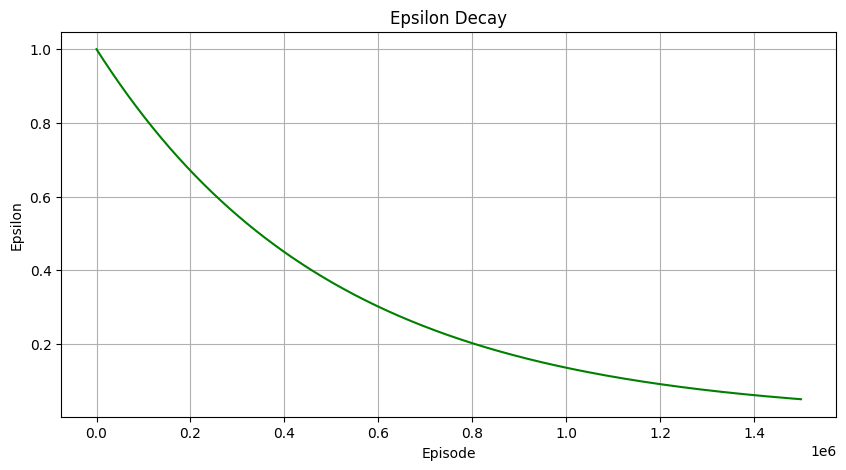

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot epsilon values
ax.plot(range(len(agent.epsilon_values)), agent.epsilon_values, color='green')

# Set labels, title, and grid
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()

plt.show()


Basic Strategy - Hard and Soft hands rules using book rules

In [17]:
class QLearningAgent_RV:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate=0.1, discount_factor=0.99):
        
        self.environment = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q_values = defaultdict(lambda: [0, 0])
        self.errors = []
        self.epsilon_values = []

        self.q_table = {}
    

     # Method to extract the policy
    def get_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            # Find the action with the highest Q-value
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy
    
     
    def get_q_table(self):
    # Generate a Q-table organized by state and actions
        for state, q_values in self.Q_values.items():
            if state not in self.q_table:
                self.q_table[state] = {}
            # Map each index in q_values to an action
            actions = ['h', 's'] 
            for action_index, action in enumerate(actions):
                self.q_table[state][action] = q_values[action_index]
        return self.q_table
    

    def select_action(self, state):
        # choose an action based on the current state
        if self.environment.has_soft_hand(self.environment.player_cards):
            return self.choose_soft_action(state)
        else: 
            return self.choose_hard_action(state)

    def choose_hard_action(self, state):
        # choose an action based on a hard hand value as per the book rules - tabel 3.1
        player_hand_value = state[0]
        dealer_up_card_value = state[1]
        if player_hand_value <= 11:
            return 'h'
        elif player_hand_value >= 17: 
            return 's'
        elif 12 <= player_hand_value <= 16 and dealer_up_card_value >= 7:
            return 'h'
        elif 12 <= player_hand_value <= 17 and 4 <= dealer_up_card_value <= 6:
            return 's'
        elif 13 <= player_hand_value <= 17 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
            return 's'
        elif player_hand_value == 12 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
            return 'h'
        else:
            return 'h' 

    def choose_soft_action(self, state):
        # choose an action based on a soft hand value as per the book rules - table 3.2
        player_hand_value = state[0]
        dealer_up_card_value = state[1]
        if player_hand_value <= 17:
            return 'h'
        elif player_hand_value == 18 and (dealer_up_card_value == 9 or dealer_up_card_value == 10):
            return 'h'
        else:
            return 's'

    def update_q_value(self, state, action, next_state, reward):
        # update the Q-value table using the Q-learning update rule
        action_index = 0 if action == 'h' else 1
        current_q = self.Q_values[state][action_index]
        next_q = max(self.Q_values[next_state])
        temporal_difference = reward + self.discount_factor * next_q - current_q
        self.Q_values[state][action_index] += self.learning_rate * temporal_difference
        self.errors.append(temporal_difference)
    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            game_done = False
            while not game_done:
                action = self.select_action(state)
                next_state, reward, game_done = self.environment.execute_action(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state

              
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)

Total time: 100.63 seconds
Basic Strategy - QLearning: Winning rate: 0.4352, Losing rate: 0.4785, Draw rate: 0.0863
TR 3919


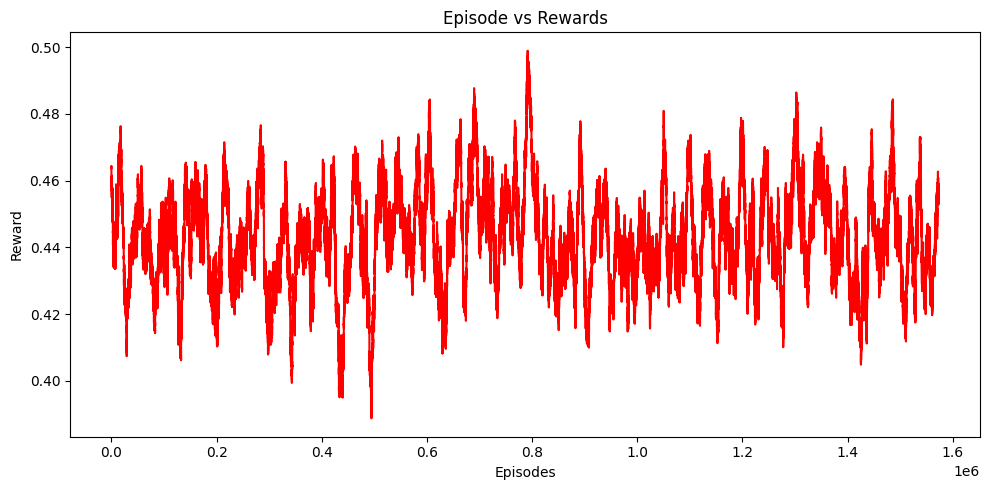

In [18]:
# training phase
start = time.time()
num_episodes = 1500000
learning_rate = 0.1
discount_factor = 1
initial_epsilon = 1.0
final_epsilon = 0.02
epsilon_decay = 0.999998
#epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)


# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent_RV = QLearningAgent_RV(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent_RV.train_agent(num_episodes)


q_table = agent_RV.get_q_table()
policy_RV = agent_RV.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    
    agent_RV.environment.reset_game()
    state = agent_RV.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent_RV.select_action(state)
        state, reward, game_done = agent_RV.environment.execute_action(action)
        total_reward += reward
        
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

print("TR",total_reward)

# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

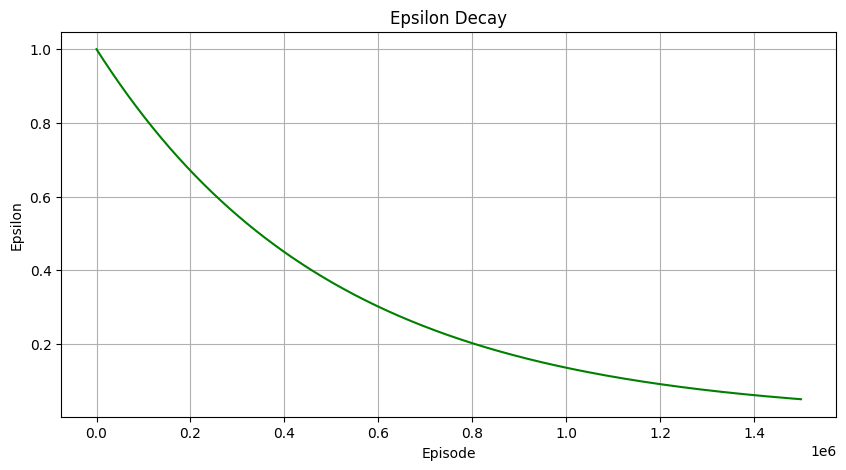

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot epsilon values
ax.plot(range(len(agent_RV.epsilon_values)), agent_RV.epsilon_values, color='green')

# Set labels, title, and grid
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()

plt.show()

In [20]:
print(policy_RV)

{(18, 2): 's', (13, 7): 'h', (23, 7): 'h', (16, 4): 's', (12, 8): 'h', (22, 8): 'h', (20, 10): 's', (15, 9): 'h', (21, 9): 's', (20, 7): 's', (6, 7): 'h', (16, 7): 'h', (24, 7): 'h', (14, 7): 'h', (21, 7): 's', (17, 10): 's', (17, 5): 's', (19, 6): 's', (20, 5): 's', (12, 4): 's', (18, 4): 's', (13, 2): 's', (12, 10): 'h', (19, 10): 's', (20, 4): 's', (11, 8): 'h', (21, 8): 's', (17, 8): 's', (12, 9): 'h', (22, 9): 'h', (14, 10): 'h', (21, 10): 's', (20, 9): 's', (16, 5): 's', (11, 10): 'h', (20, 8): 's', (13, 5): 's', (9, 10): 'h', (24, 10): 'h', (13, 3): 's', (14, 6): 's', (17, 6): 's', (15, 10): 'h', (18, 10): 's', (16, 10): 'h', (26, 10): 'h', (11, 5): 'h', (18, 5): 's', (10, 8): 'h', (13, 8): 'h', (18, 8): 's', (15, 2): 's', (12, 2): 'h', (7, 4): 'h', (17, 4): 's', (15, 5): 's', (13, 4): 's', (5, 8): 'h', (12, 11): 'h', (22, 11): 'h', (10, 10): 'h', (19, 4): 's', (14, 8): 'h', (22, 10): 'h', (20, 3): 's', (19, 8): 's', (12, 5): 's', (10, 7): 'h', (15, 8): 'h', (7, 2): 'h', (10, 2)

SARSA learning approach

In [29]:
#SARSA - change in update rule
class SARSAAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.01, gamma=0.99):
        # initialize the SARSA agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = initial_epsilon
        self.initial_epsilon = initial_epsilon  # exploration rate
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []

    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
        # choose an action to take in the given state based on the current Q-values and exploration rate
        if np.random.random() < self.epsilon:
            return random.choice(['h', 's'])
        else:
            return max(['h', 's'], key=lambda action: self.Q_values.get((state, action), 0))

    def update_q_value(self, state, action, next_state, next_action, reward):
        # Get the current Q-value for the given state-action pair
        current_q = self.Q_values.get((state, action), 0)

        # Get the Q-value for the next state and the next action
        # This is the key difference from Q-learning, where we consider the Q-value of the next action
        next_q = self.Q_values.get((next_state, next_action), 0)
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference

    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    
    def train_agent(self, num_episodes):
        # train the SARSA agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            action = self.select_action(state)
            done = False
            while not done:
                next_state, reward, done = self.environment.execute_action(action)
                next_action = self.select_action(next_state)
                self.update_q_value(state, action, next_state, next_action, reward)
                state = next_state  
                action = next_action
            
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)

In [30]:
# training
start = time.time()
num_episodes = 1500000

learning_rate = 0.1
discount_factor = 1
initial_epsilon = 1.0
final_epsilon = 0.02
epsilon_decay = 0.999998

# Initialize the environment and the SARSA agent
environment = BlackjackEnvironment()
agent = SARSAAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate,discount_factor)
agent.train_agent(num_episodes)

# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.execute_action(action)
        total_reward += reward
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
print("Total reward",total_reward)
winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - SARSA - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

Total time: 110.88 seconds
Total reward 2650
Basic Strategy - SARSA - Winning rate: 0.3983, Losing rate: 0.5316, Draw rate: 0.0701
